# Kaggle: Plant Pathology 2021 - FGVC8

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Borda/kaggle_plant-pathology/blob/main/notebooks/Plant-Pathology-with-Lightning.ipynb)

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [2]:
from google.colab import drive
# connect to  my gDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# copy the dataset to local drive
! rsync -ah --progress /content/gdrive/Shareddrives/Datasets/Kaggle/Plant-pathology/plant-pathology-2021-fgvc8_640.zip plant-pathology.zip

sending incremental file list
plant-pathology-2021-fgvc8_640.zip
        683.08M 100%  111.24MB/s    0:00:05 (xfr#1, to-chk=0/1)


In [4]:
! rm -rf train_images/
! rm -rf test_images/

# extract dataset to the drive
! unzip plant-pathology.zip | awk 'BEGIN {ORS=" "} {if(NR%250==0)print "."}'
! ls -l

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . total 668408
drwx------ 6 root root      4096 May 20 04:48 gdrive
-rw------- 1 root root 683081584 Apr  6 21:19 plant-pathology.zip
drwxr-xr-x 1 root root      4096 May  6 13:44 sample_data
-rw-r--r-- 1 root root       100 Mar 11 21:00 sample_submission.csv
drwxr-xr-x 2 root root      4096 Apr  3 08:02 test_images
-rw-r--r-- 1 root root    586183 Apr  6 21:18 train.csv
drwxr-xr-x 2 root root    757760 Apr  3 08:06 train_images


In [1]:
! pip install -q -U pytorch-lightning torchmetrics
! pip install -q https://github.com/Borda/imbalanced-dataset-sampler/archive/refs/heads/master.zip
! pip install -q https://github.com/Borda/kaggle_plant-pathology/archive/devel.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch
! pip list | grep kaggle

pytorch-lightning             1.3.2         
torch                         1.8.1+cu101   
torchmetrics                  0.3.2         
torchsampler                  0.1.1         
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   
kaggle                        1.5.12        
kaggle-plant-pathology        0.4.2         


In [2]:
! nvidia-smi

Thu May 20 04:50:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data exploration

Checking what data do we have available and what is the labels distribution...

In [3]:
# ! apt-get install -qq -y imagemagick
# ! mogrify -resize 960 train_images/*.jpg

Looking in the training dataset table, what colums and what is the data representation...

In [4]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pprint import pprint

base_path = '/content'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
print(train_data.head())

                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex


We can see that each image can have multiple labels so lets check what is the mos common label count...

*The target classes, a space delimited list of all diseases found in the image.
Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.*

In [5]:
train_data['nb_classes'] = [len(lbs.split(" ")) for lbs in train_data['labels']]
lb_hist = dict(zip(range(10), np.bincount(train_data['nb_classes'])))
pprint(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


Browse the label distribution, enrolling all labels in the dataset, so in case an image has two labels both are used in this stat...

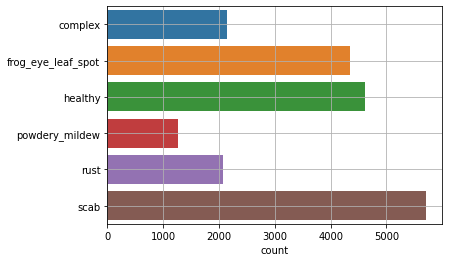

In [ ]:
import itertools

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data['labels']]))

ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

Get some stat for labels combinations...

In [7]:
labels_unique = set(labels_all)
print(f"unique labels: {labels_unique}")
train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

labels_combine = {}
for comb in train_data['labels_sorted']:
    labels_combine[comb] = labels_combine.get(comb, 0) + 1

show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
print(f"unique combinations: \n" + show_counts)
print(f"total: {sum(labels_combine.values())}")

unique labels: {'frog_eye_leaf_spot', 'healthy', 'complex', 'rust', 'scab', 'powdery_mildew'}
unique combinations: 
	complex frog_eye_leaf_spot scab: 200
	complex frog_eye_leaf_spot: 165
	complex powdery_mildew: 87
	complex rust: 97
	complex: 1602
	frog_eye_leaf_spot rust: 120
	frog_eye_leaf_spot scab: 686
	frog_eye_leaf_spot: 3181
	healthy: 4624
	powdery_mildew: 1184
	rust: 1860
	scab: 4826
total: 18632


And add visualisation over each case, so five a few examples per labe combination...

(-0.5, 639.5, 427.5, -0.5)

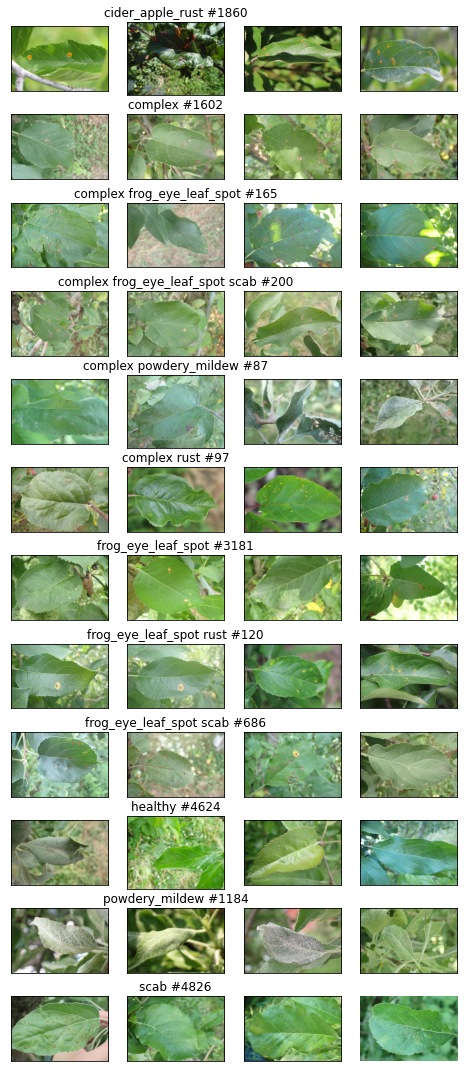

In [ ]:
nb_samples = 4
n, m = len(np.unique(train_data['labels_sorted'])), nb_samples
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 1.6))
for ilb, (lb, df_) in enumerate(train_data.groupby('labels_sorted')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 1:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

In [9]:
# import os, tqdm

# images_path = "/content/train_images"

# clr_images = {0: [], 1: [], 2: []}
# # just some smaller subset bc there is some random freezing without proper error/exception
# for img_name in tqdm.tqdm(list(train_data['image'])):
#   img = plt.imread(os.path.join(images_path, img_name))
#   for i in range(3):  # aggregate means per channel
#     clr_images[i].append(np.mean(img[..., i]))

# img_color_mean = [np.mean(clr_images[i]) for i in range(3)]
# print(np.array(img_color_mean) / 255.0)

In [10]:
# clr_images = {0: [], 1: [], 2: []}
# # just some smaller subset bc there is some random freezing without proper error/exception
# for img_name in tqdm.tqdm(list(train_data['image'])):
#   img = plt.imread(os.path.join(images_path, img_name))
#   for i in range(3):  # compute STD per channel
#     std = np.sqrt(np.mean((img[..., i] - img_color_mean[i]) ** 2))
#     clr_images[i].append(np.mean(std))

# img_color_std = [np.mean(clr_images[i]) for i in range(3)]
# print(np.array(img_color_std) / 255.0)

## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations.
We define the sample pair as:
 - RGB image
 - one-hot labels encoding

A DataModule standardizes the training, val, test splits, data preparation and transforms.
The main advantage is consistent data splits, data preparation and transforms across models.

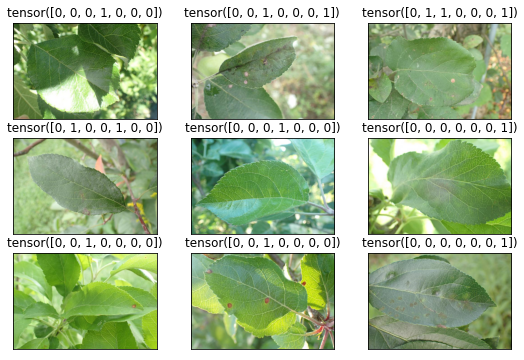

In [ ]:
import os
import torch

from kaggle_plantpatho.data import PlantPathologyDataset

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

The DataModule include creating training and validation dataset with given split and feading it to particular data loaders...

batch labels: tensor([12, 30, 22,  8, 11, 24])
image size: torch.Size([3, 224, 224])


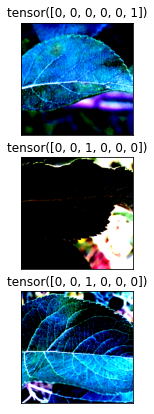

In [12]:
from kaggle_plantpatho.augment import TORCHVISION_TRAIN_TRANSFORM, TORCHVISION_VALID_TRANSFORM
from kaggle_plantpatho.data import PlantPathologyDM

dm = PlantPathologyDM(
    simple=False,
    batch_size=98,
    train_transforms=TORCHVISION_TRAIN_TRANSFORM,
    valid_transforms=TORCHVISION_VALID_TRANSFORM,
    split=0.9,
    balancing=True,
)
dm.setup()

# Quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.val_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some stanrd CNN models taken from torch vision.
Then we define Ligthning module including training and validation step and configure optimizer/schedular.

In [13]:
from kaggle_plantpatho.models import LitResnet, MultiPlantPathology

# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch='resnext101_32x8d', num_classes=dm.num_classes)
# print(net)

# Learning rate set to 0.0006309573444801932  # this is product of LR finder
model = MultiPlantPathology(model=net, lr=6e-4)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [ ]:
import pytorch_lightning as pl
print(pl.__version__)

logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid_f1',
    save_top_k=1,
    save_last=True,
    # save_weights_only=True,
    filename='checkpoint/{epoch:02d}-{valid_acc:.4f}-{valid_f1:.4f}',
    # verbose=False,
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    callbacks=[ckpt, swa],
    logger=logger,
    max_epochs=35,
    precision=16,
    #overfit_batches=5,
    auto_lr_find=True,
    accumulate_grad_batches=24,
    val_check_interval=0.5,
    progress_bar_refresh_rate=1,
    weights_summary='top',
)

# ==============================

# lr_find_kwargs = dict(min_lr=1e-5, max_lr=1e-2, num_training=25)
# trainer.tune(model, datamodule=dm, lr_find_kwargs=lr_find_kwargs)
# print(f"LR: {model.learning_rate}")

# ==============================

trainer.fit(model=model, datamodule=dm)

Quick visualization of the training process...

   valid_loss  valid_acc  valid_prec  ...  train_acc  train_prec  train_f1
0    0.725391   0.823945    0.583774  ...        NaN         NaN       NaN
1    0.663098   0.920064    0.861811  ...        NaN         NaN       NaN
2    0.648380   0.948408    0.923316  ...        NaN         NaN       NaN
3    0.652555   0.938215    0.926732  ...        NaN         NaN       NaN
4    0.643332   0.959049    0.946289  ...        NaN         NaN       NaN

[5 rows x 10 columns]


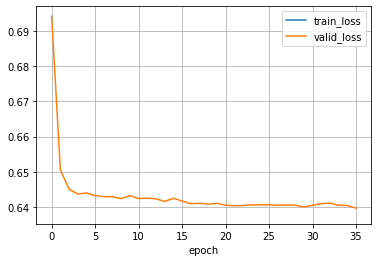

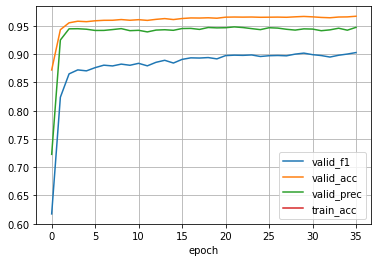

In [15]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
display(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train_loss', 'valid_loss']].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[['valid_f1', 'valid_acc', 'valid_prec', 'train_acc']].plot(grid=True, legend=True, xlabel=agg_col)

## Predictions on tests data

Run simple predictions on testing data and form in expected output

image size: torch.Size([3, 224, 224])


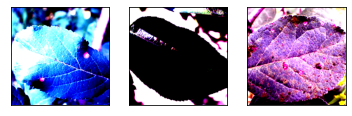

In [16]:
fig = plt.figure(figsize=(6, 2))
for imgs, lbs in dm.test_dataloader():
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3) + 0.5)
    break

In [17]:
preds = []
dm.batch_size = 8
model.eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        encode = model(imgs)
    print(np.round(encode.detach().numpy(), decimals=2))
    for be, name in zip(encode, names):
        lbs = dm.binary_encoding_to_labels(be)
        preds.append(dict(image=name, labels=" ".join(lbs)))
    break

df_preds = pd.DataFrame(preds)
print(df_preds.head())

[[0.   1.   0.   0.   0.   0.05]
 [0.   0.   0.   0.   0.   1.  ]
 [0.98 0.   0.   0.   0.   0.  ]]
                  image              labels
0  c7b03e718489f3ca.jpg  frog_eye_leaf_spot
1  85f8cb619c66b863.jpg                scab
2  ad8770db05586b59.jpg             complex


In [18]:
df_preds['labels'] = [lbs or "healthy" for lbs in df_preds['labels']]
print(df_preds.head())
df_preds.to_csv('submission.csv', index=False)

                  image              labels
0  c7b03e718489f3ca.jpg  frog_eye_leaf_spot
1  85f8cb619c66b863.jpg                scab
2  ad8770db05586b59.jpg             complex


## Replicate

dump the trained model and try to load it again to see if it gives the same results...

### Save with plain PyTorch

In [19]:
torch.save(model.model, f'fgvc8_{net.arch}.pt')

net2 = torch.load(f'fgvc8_{net.arch}.pt')
model2 = MultiPlantPathology(model=net2)

In [20]:
preds = []
model2.eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        encode = model2(imgs)
    print(np.round(encode.detach().numpy(), decimals=2))
    break

[[0.   1.   0.   0.   0.   0.05]
 [0.   0.   0.   0.   0.   1.  ]
 [0.98 0.   0.   0.   0.   0.  ]]


In [21]:
! cp fgvc8_resnext101_32x8d.pt /content/gdrive/Shareddrives/Datasets/Kaggle/Plant-pathology/

### Save with Pytorch-Lignnting ckpt

In [22]:
! ls -l logs/resnet50/version_*/checkpoints/checkpoint
print(ckpt.best_model_path)
# print(vars(ckpt))

ls: cannot access 'logs/resnet50/version_*/checkpoints/checkpoint': No such file or directory
logs/resnext101_32x8d/version_0/checkpoints/checkpoint/epoch=28-valid_acc=0.9674-valid_f1=0.9037.ckpt


In [23]:
net3 = LitResnet(arch=net.arch, num_classes=dm.num_classes)
model3 = MultiPlantPathology(model=net3)
weight = torch.load(ckpt.last_model_path, map_location=torch.device('cpu'))
model3.load_state_dict(weight['state_dict'])
# model2 = MultiPlantPathology.load_from_checkpoint(ckpt.best_model_path)

<All keys matched successfully>

In [24]:
preds = []
model3.eval()

for imgs, names in dm.test_dataloader():
    with torch.no_grad():
        encode = model3(imgs)
    print(np.round(encode.detach().numpy(), decimals=2))
    break

[[0.   1.   0.   0.   0.   0.05]
 [0.   0.   0.   0.   0.   1.  ]
 [0.96 0.   0.   0.   0.   0.01]]
